In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs 
# from typing import Dict, List, Text, Union, Any
import warnings
warnings.filterwarnings("ignore")

2024-10-25 02:48:44.566502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# loading the data sources
user_movie_title_rating_data = pd.read_csv('sliced_user_id_and_movie_title_data.csv')
# loading the data sources
# user_rating_data = pd.read_csv('/Users/eugene/Personal_Projects/Real_ML_Project/imdb_dataset/title.user-rating.csv')
# movie_data = pd.read_csv('/Users/eugene/Personal_Projects/Real_ML_Project/imdb_dataset/title.basics.csv')
# average_rating_data =  pd.read_csv('/Users/eugene/Personal_Projects/Real_ML_Project/imdb_dataset/title.ratings.csv')
# basics_data = pd.read_csv('/Users/eugene/Personal_Projects/Real_ML_Project/imdb_dataset/name.basics.csv')
# principals_data = pd.read_csv('/Users/eugene/Personal_Projects/Real_ML_Project/imdb_dataset/title.principals.csv')

In [ ]:
# # rename the tconst to movieID
# movie_data.rename(columns={'tconst': 'movieID'}, inplace=True)
# movie_data.head()

In [ ]:
# # performing a merge operation to expand the user rating data with movie titles
# user_rating_data_with_movies_title = user_rating_data.merge(movie_data, how='left', on='movieID')
# user_rating_data_with_movies_title = user_rating_data_with_movies_title[['userID', 'movieID','originalTitle', 'rating', 'review date']]
# user_rating_data_with_movies_title.head()

In [ ]:
# # experimental step of extracting just a slice of our data for testing purposes
# sliced_user_id_and_movie_title_data = user_rating_data_with_movies_title[0:50000]
# print(sliced_user_id_and_movie_title_data.size, sliced_user_id_and_movie_title_data.shape)

In [3]:
user_movie_title_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userID         50000 non-null  object
 1   movieID        50000 non-null  object
 2   originalTitle  49996 non-null  object
 3   rating         50000 non-null  int64 
 4   review date    50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [4]:
# create a new movie title list that enforces type uniformity in its values
# this step came up because of type inconsitency when creating movie title vocabulary
updated_movie_titles = []
for i in user_movie_title_rating_data['originalTitle']:
    if type(i) != 'str':
        a = str(i)
        updated_movie_titles.append(a)
    else:
        updated_movie_titles.append(i)

In [5]:
user_movie_title_rating_data['originalTitle'] = updated_movie_titles
user_movie_title_rating_data['originalTitle']

0                                 When the Light Comes
1                                       Batman & Robin
2        Bottom Live 2003: Weapons Grade Y-Fronts Tour
3                                            Alexander
4                                          Beetlejuice
                             ...                      
49995               The Five People You Meet in Heaven
49996                                         Sin City
49997                                         Earthsea
49998                                           L√©olo
49999                                           Sahara
Name: originalTitle, Length: 50000, dtype: object

In [6]:
user_movie_title_rating_data.head()

,userID,movieID,originalTitle,rating,review date
0,ur4592644,tt0120884,When the Light Comes,10,16 January 2005
1,ur3174947,tt0118688,Batman & Robin,3,16 January 2005
2,ur3780035,tt0387887,Bottom Live 2003: Weapons Grade Y-Fronts Tour,8,16 January 2005
3,ur4592628,tt0346491,Alexander,1,16 January 2005
4,ur3174947,tt0094721,Beetlejuice,8,16 January 2005


In [7]:
user_movie_title_rating_data[user_movie_title_rating_data['originalTitle']== 'Constantine']

,userID,movieID,originalTitle,rating,review date
8602,ur1284280,tt0360486,Constantine,8,1 February 2005
8941,ur3353587,tt0360486,Constantine,4,1 February 2005
8943,ur2789953,tt0360486,Constantine,3,1 February 2005
8944,ur4652689,tt0360486,Constantine,3,1 February 2005
11398,ur2384861,tt0360486,Constantine,8,5 February 2005
...,...,...,...,...,...
48366,ur1003768,tt0360486,Constantine,9,24 April 2005
48669,ur4884256,tt0360486,Constantine,8,25 April 2005
49318,ur3145988,tt0360486,Constantine,6,26 April 2005
49383,ur5211021,tt0360486,Constantine,2,27 April 2005


In [8]:
# convert the pandas dataframe to tensorflow tensor dataset
user_movie_title_rating_data_tensor = tf.data.Dataset.from_tensor_slices(
    user_movie_title_rating_data.to_dict('list'))


In [9]:
for i in user_movie_title_rating_data_tensor.take(1).as_numpy_iterator():
    print(i)

{'userID': b'ur4592644', 'movieID': b'tt0120884', 'originalTitle': b'When the Light Comes', 'rating': 10, 'review date': b'16 January 2005'}


In [10]:
# extract the needed features from our tensors
user_movie_title_rating_data_tensor_new = user_movie_title_rating_data_tensor.map(lambda x: {
    "userID": x["userID"],
    "originalTitle": x["originalTitle"]
})

In [11]:
# extract movie title dictionary. 
# Format required for training the model - during the retrievel task operation where the metrics is computed
movie_titles_dict = user_movie_title_rating_data_tensor_new.map(lambda x : {
    'originalTitle': x['originalTitle'],
})

In [12]:
# shuffle dataset and split
tf.random.set_seed(42)
user_movie_title_rating_data_tensor_shuffled = user_movie_title_rating_data_tensor_new .shuffle(50000, seed=42, reshuffle_each_iteration=False)

# split the data into train, test and validation
train = user_movie_title_rating_data_tensor_shuffled.take(30000)
test = user_movie_title_rating_data_tensor_shuffled.skip(30000).take(10000)
validation = user_movie_title_rating_data_tensor_shuffled.skip(40000).take(10000)

In [13]:
# obtain unique ids and titles which will be embedded and used for our model architecture
user_ids = user_movie_title_rating_data_tensor_shuffled.batch(500).map(
    lambda x: x['userID']
)
movie_titles = user_movie_title_rating_data_tensor_shuffled.batch(500).map(
    lambda x: x['originalTitle']
)

unique_user_ids = np.unique(np.concatenate(list(user_ids), axis=0))
unique_movie_titles = np.unique(np.concatenate(list(movie_titles), axis=0))

## Implementing the Model Architecture - A two tower retrieval model

## Query Tower - User Model (user id and sample movie already watched)

In [22]:
# defining the two models
embedding_dimension = 64

class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'user_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_user_ids) + 1,
                output_dim = embedding_dimension),
            tf.keras.layers.Flatten(name='FlattenUser')
            ])
        self.movie_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'movie_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_movie_titles) + 1, 
                output_dim = embedding_dimension),
            tf.keras.layers.Flatten(name='FlattenUserMovie')
        ])

    def call(self, inputs):
        return tf.concat([
            self.user_query_model(inputs['userID']),
            self.movie_query_model(inputs['originalTitle']),
        ],
        axis=1
        )


## Candidate Tower - Movie Model (movie titles only)

In [23]:
embedding_dimension = 64

class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.movie_candidate_model =  tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'movie_title', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])
    
    def call(self, inputs):
        return self.movie_candidate_model(inputs['originalTitle'])
    

In [24]:

class IMDBModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.query_model = tf.keras.Sequential([
            UserModel(),
            tf.keras.layers.Dense(32, activation="relu"),
        ])
        self.candidate_model = tf.keras.Sequential([
            MovieModel(),
            tf.keras.layers.Dense(32, activation="relu"),
        ])
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movie_titles_dict.batch(100).map(self.candidate_model)
            )
        )
    
    def compute_loss(self, input, training=False) -> tf.Tensor:

        user_query_embedding = self.query_model({
            "userID": input['userID'],
            "originalTitle": input['originalTitle']
            
        })
        candidate_embedding = self.candidate_model(
            {
                "originalTitle": input['originalTitle']
            }
        )

        loss_and_metrics = self.task(user_query_embedding, candidate_embedding)

        return loss_and_metrics

In [25]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7),
    tf.keras.callbacks.ModelCheckpoint(filepath='./logs/models/.weights.h5', save_weights_only=True, save_best_only=True, save_freq="epoch",),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# Create a retrieval model.
model = IMDBModel()
model.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )

# shuffle, batch, and cache the training and evaluation data
cached_train = train.shuffle(6000).batch(500).cache()
cached_test = test.batch(100).cache()
cached_val = validation.batch(100).cache()


In [26]:
start_train = True

if start_train: 
    history = model.fit(
        x=cached_train,
        epochs=5,
        verbose=True,
        batch_size=16,
        validation_data=cached_val,
        callbacks=callbacks,
    )

Epoch 1/5


2024-10-25 03:04:05.940086: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


60/60 [==============================] - 124s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0527 - factorized_top_k/top_5_categorical_accuracy: 0.0558 - factorized_top_k/top_10_categorical_accuracy: 0.0580 - factorized_top_k/top_50_categorical_accuracy: 0.0653 - factorized_top_k/top_100_categorical_accuracy: 0.0737 - loss: 3091.0592 - regularization_loss: 0.0000e+00 - total_loss: 3091.0592 - val_factorized_top_k/top_1_categorical_accuracy: 0.0701 - val_factorized_top_k/top_5_categorical_accuracy: 0.0716 - val_factorized_top_k/top_10_categorical_accuracy: 0.0747 - val_factorized_top_k/top_50_categorical_accuracy: 0.0780 - val_factorized_top_k/top_100_categorical_accuracy: 0.0842 - val_loss: 447.6161 - val_regularization_loss: 0.0000e+00 - val_total_loss: 447.6161
Epoch 2/5
60/60 [==============================] - 125s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0783 - factorized_top_k/top_5_categorical_accuracy: 0.0798 - factorized_top_k/top_10_categorical_accura

In [27]:
if start_train:
    model.save_weights(filepath='./weights/trained_n_personalized_model', overwrite=True)

## Evaluation

In [28]:
history.history['loss']

[3045.552490234375,
 2535.493896484375,
 2001.839599609375,
 1485.9749755859375,
 1021.3511962890625]

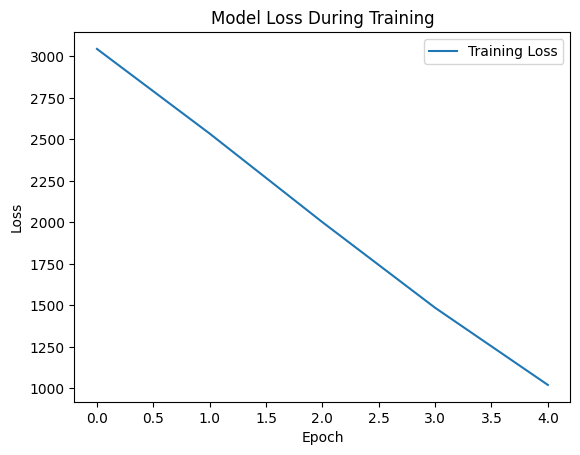

In [29]:
# plotting changes in model loss during training
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [30]:
# evaluating our model on train and test set
top_100_train_accuracy = model.evaluate(cached_train, return_dict=True)['factorized_top_k/top_100_categorical_accuracy']
top_100_test_accuracy = model.evaluate(cached_test, return_dict=True)['factorized_top_k/top_100_categorical_accuracy']


print(f'Top 100 train accuracy: {top_100_train_accuracy:.2f}.')
print(f'Top 100 test accuracy: {top_100_test_accuracy:.2f}.')

100/100 [==============================] - 75s 752ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3051 - factorized_top_k/top_5_categorical_accuracy: 0.3433 - factorized_top_k/top_10_categorical_accuracy: 0.3999 - factorized_top_k/top_50_categorical_accuracy: 0.5209 - factorized_top_k/top_100_categorical_accuracy: 0.5541 - loss: 194.0573 - regularization_loss: 0.0000e+00 - total_loss: 194.0573
Top 100 train accuracy: 0.70.
Top 100 test accuracy: 0.55.


## Serving

In [31]:
# obtaining the movie ids and their titles
index_movie = dict(user_movie_title_rating_data[['movieID', 'originalTitle']].to_numpy())

In [35]:
# creating first 10 recommendations by retrieval
# creating a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model, k=10)

# recommends movies out of the entire movies dataset.
index.index_from_dataset(
    tf.data.Dataset.zip((movie_titles_dict.batch(100).map(lambda x: x['originalTitle']), 
                         movie_titles_dict.batch(100).map(lambda x : {
    'originalTitle': x['originalTitle']}).map(model.candidate_model)))
)


# Get recommendations.
_, titles = index({
    'userID': tf.constant(["ur3174947"]),
    'originalTitle': tf.constant(["Beetlejuice"]),
    })

print("Recommendations for user ur3174947 who watched the movie Beetlejuice")

titles = [idx.decode('utf-8') for idx in titles[0, :5].numpy()]
print(titles)

Recommendations for user ur3174947 who watched the movie Beetlejuice
['Ryan', 'Ryan', 'Ryan', 'Ryan', 'Ryan']
